# Fire Incident Analysis
This notebook analyzes active fire detections from the VIIRS instrument onboard the Suomi NPP satellite, based on data from July 12, 2023. It covers EDA, classification of fire confidence, prediction of Fire Radiative Power (FRP), and anomaly detection.

## 1. Data Loading & Setup
We begin by importing necessary libraries and loading the FIRMS dataset.

In [192]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor, IsolationForest
from sklearn.metrics import classification_report, mean_squared_error, r2_score
import geopandas as gpd
import geodatasets
import warnings

warnings.filterwarnings('ignore')
df = pd.read_csv("sample_viirs_snpp_071223.csv")
df.head()

,latitude,longitude,bright_ti4,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_ti5,frp,daynight
0,0.05836,29.59085,295.64,0.38,0.59,2023-07-12,3,N,VIIRS,n,2.0NRT,275.15,0.83,N
1,0.48765,31.50760,296.73,0.51,0.66,2023-07-12,3,N,VIIRS,n,2.0NRT,275.15,0.56,N
2,2.15227,13.94524,305.26,0.51,0.49,2023-07-12,3,N,VIIRS,n,2.0NRT,287.94,1.08,N
3,2.15681,13.94618,319.05,0.51,0.49,2023-07-12,3,N,VIIRS,n,2.0NRT,288.77,1.81,N
4,2.15754,13.94131,301.13,0.51,0.50,2023-07-12,3,N,VIIRS,n,2.0NRT,288.17,1.81,N


### Column Descriptions for VIIRS SNPP Fire Dataset

1. **latitude**  
   Geographic latitude of the fire detection point, in decimal degrees.

2. **longitude**  
   Geographic longitude of the fire detection point, in decimal degrees.

3. **bright_ti4**  
   Brightness temperature (Kelvin) from VIIRS M13 (I4) channel, sensitive to mid-infrared wavelengths.

4. **scan**  
   Spatial resolution across the satellite track, in degrees.

5. **track**  
   Spatial resolution along the satellite track, in degrees.

6. **acq_date**  
   Acquisition date of the fire detection in `YYYY-MM-DD` format.

7. **acq_time**  
   Acquisition time of the detection in `HHMM` 24-hour format (UTC).

8. **satellite**  
   Satellite identifier:  
   - `'N'` = Suomi NPP

9. **instrument**  
   Instrument used for detection:  
   - `'VIIRS'` = Visible Infrared Imaging Radiometer Suite

10. **confidence**  
    Confidence level of the detection:  
    - `'l'` = low  
    - `'n'` = nominal  
    - `'h'` = high

11. **version**  
    Processing version of the data:  
    - `'2.0NRT'` = Near Real-Time  
    - `'2.0URT'` = Ultra Real-Time

12. **bright_ti5**  
    Brightness temperature (Kelvin) from VIIRS M15 (I5) channel, sensitive to thermal infrared wavelengths.

13. **frp**  
    Fire Radiative Power (MW), representing the intensity of the fire.

14. **daynight**  
    Indicates whether the detection was during:  
    - `'D'` = Day  
    - `'N'` = Night


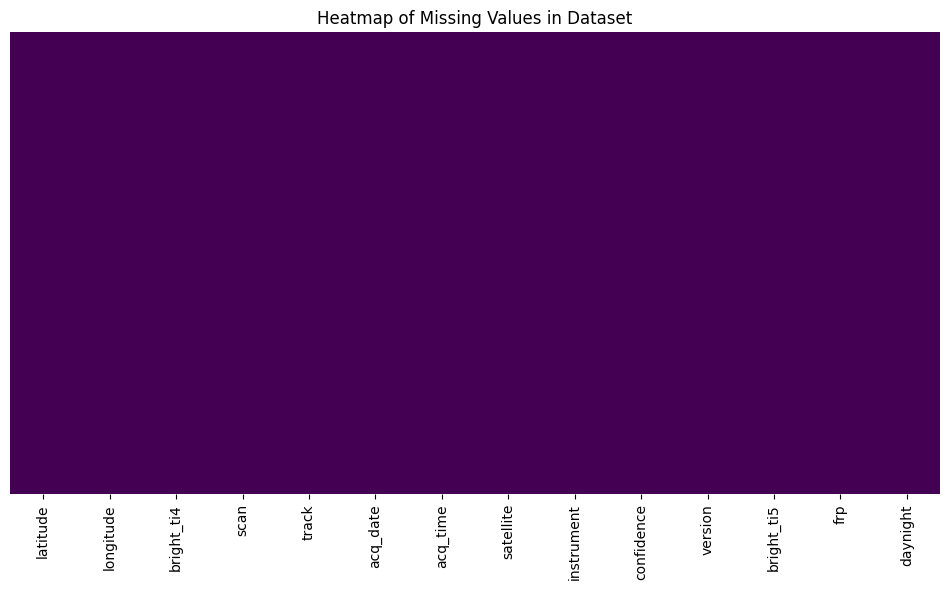

In [161]:
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Heatmap of Missing Values in Dataset')
plt.show()

No null values, we love to see it. 

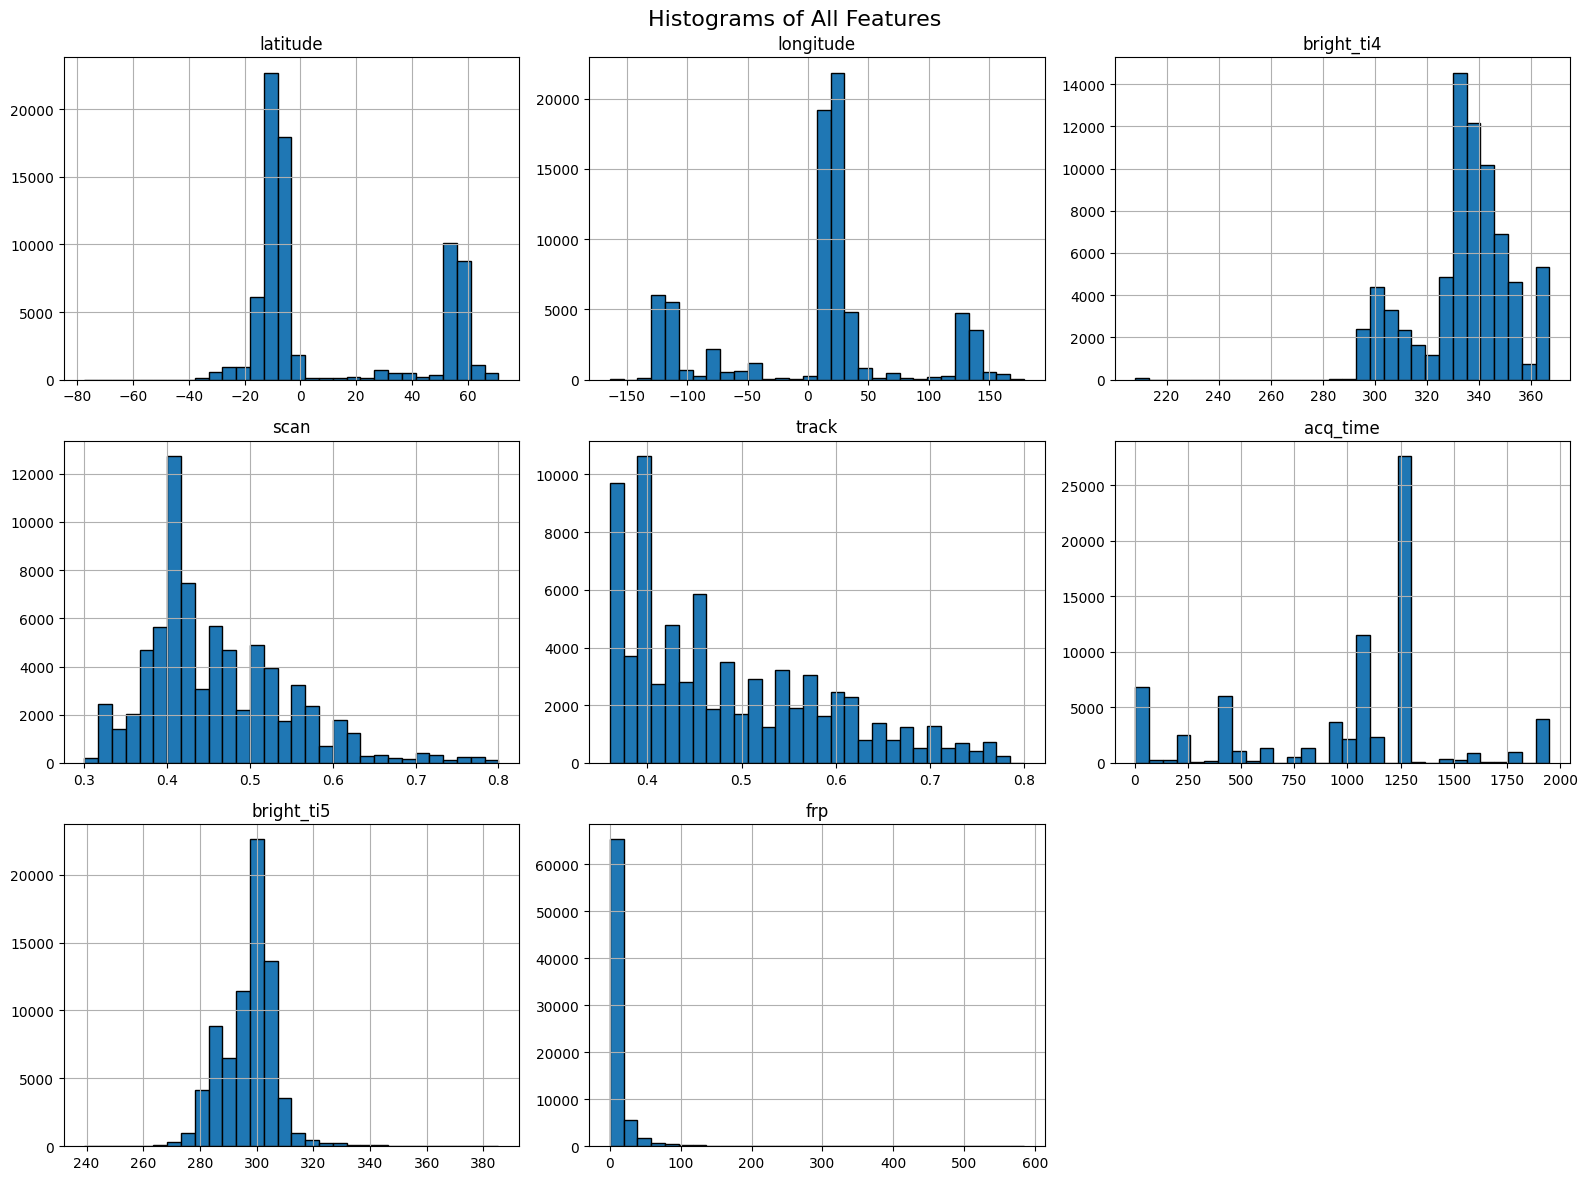

In [162]:
df.hist(bins=30, figsize=(16, 12), edgecolor='black')
plt.suptitle('Histograms of All Features', fontsize=16)
plt.tight_layout()
plt.show()



#### 1. `latitude` and `longitude`
- Both features show **multimodal distributions**, suggesting that fire detections are geographically clustered in several global regions.
- `latitude` peaks heavily around tropical and subtropical zones, with notable density in both the southern and northern hemispheres.
- `longitude` exhibits peaks aligned with landmasses like Africa, South America, and Southeast Asia.

#### 2. `bright_ti4` and `bright_ti5`
- `bright_ti4` (mid-infrared brightness) is **right-skewed**, with values concentrated between 300K and 360K. A sharp upper edge suggests sensor saturation or clipping.
- `bright_ti5` (thermal infrared) is more **normally distributed**, centered tightly around 300K, indicating consistent thermal signal readings for fire sources.

#### 3. `scan` and `track`
- Both sensor geometry features are **skewed left** with clear peaks around 0.4.
- These values reflect **observation resolution** and satellite angle geometry, with denser detections in favorable sensor positions.

#### 4. `acq_time`
- Displays a **strong spike around 1300 (UTC)**, indicating most acquisitions occur during a specific satellite overpass time.
- The rest of the distribution is irregular, showing some periodicity from orbital patterns.

#### 5. `frp` (Fire Radiative Power)
- Highly **right-skewed**, with most fire detections having low FRP values (< 50).
- A long tail extends beyond 500, reflecting rare but extremely intense fire events.


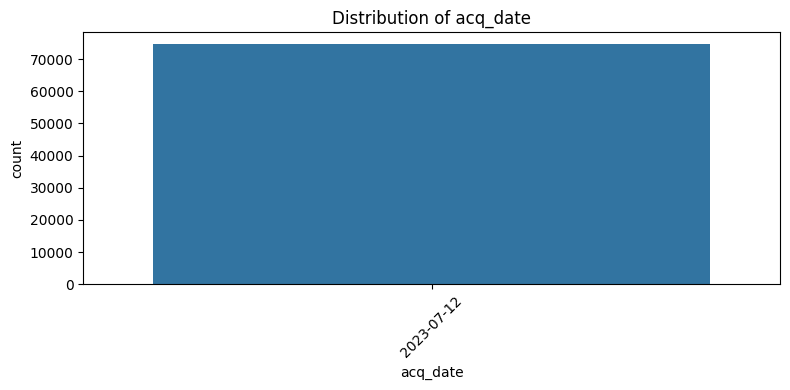

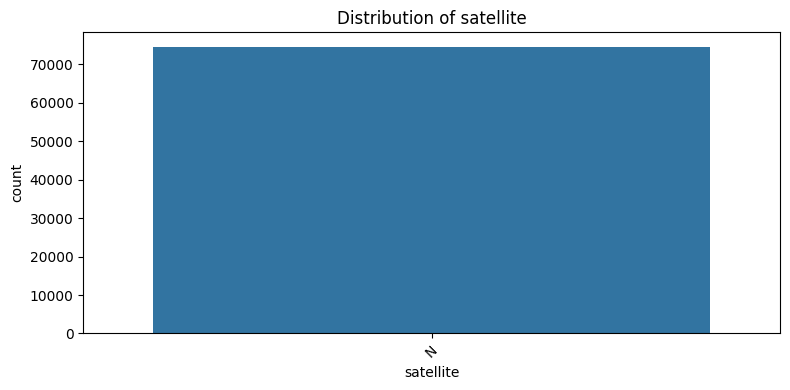

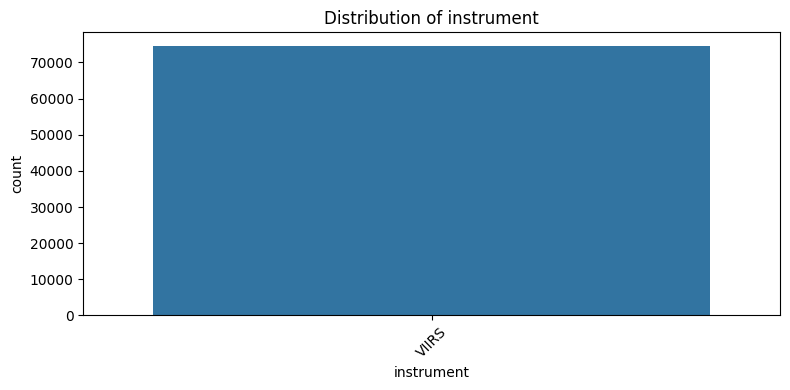

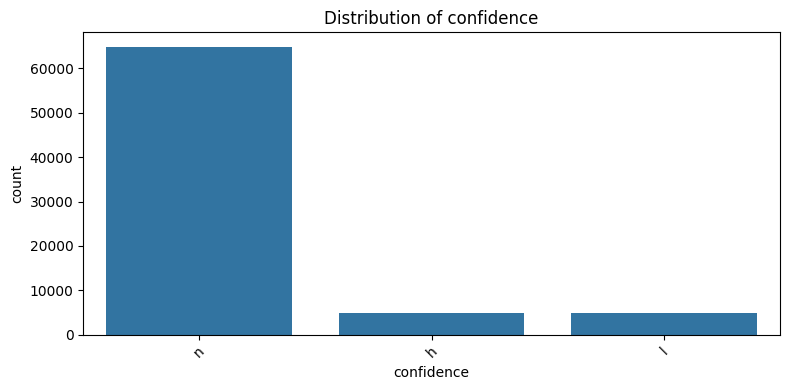

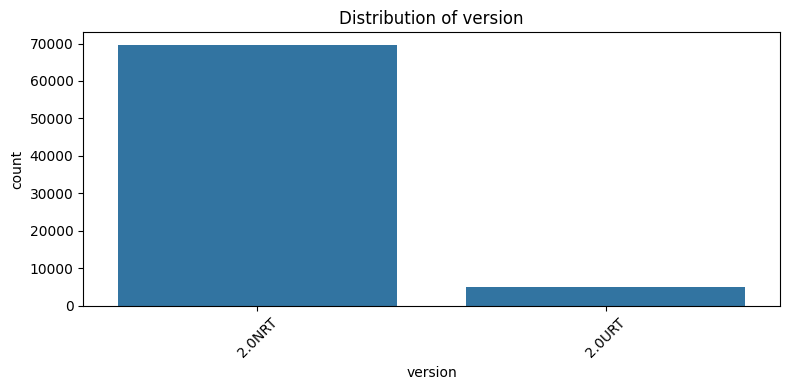

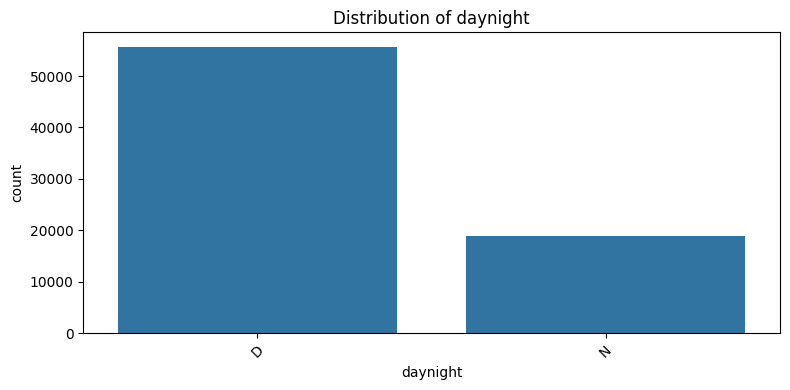

In [210]:
import seaborn as sns
import matplotlib.pyplot as plt

# Identify categorical columns (excluding numerical types)
categorical_cols = df.select_dtypes(include='object').columns

# Create countplots for each
for col in categorical_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=df, x=col, order=df[col].value_counts().index)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Since we only have one record for acq_date, satellite, and instrument, these features can be dropped. Version simply informs us about the quality of data, so it's a redundant feature as well.

## 2. Data Cleaning and Feature Engineering
We clean confidence levels and combine acquisition date and time into a single datetime column.

In [164]:
confidence_mapping = {'l': 'Low', 'n': 'Nominal', 'h': 'High'}
df['confidence'] = df['confidence'].str.lower().map(confidence_mapping)
df['acq_datetime'] = pd.to_datetime(df['acq_date'] + ' ' + df['acq_time'].astype(str).str.zfill(4), format='%Y-%m-%d %H%M')

## Class Distribution of Confidence Levels
Understanding the class balance is crucial for interpreting model performance. An imbalance can lead to high accuracy on dominant classes and poor generalization on minority ones.

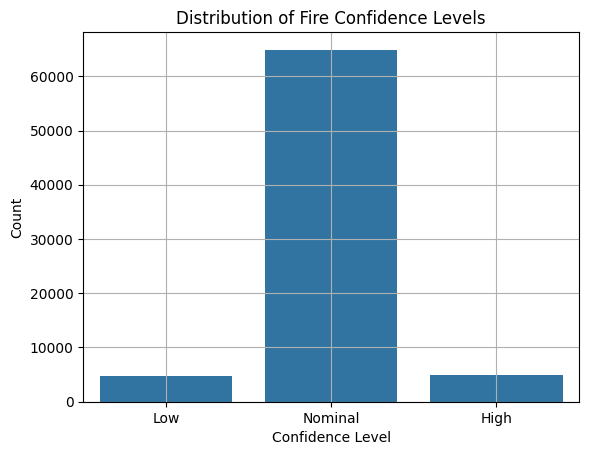

In [165]:
sns.countplot(data=df, x='confidence', order=['Low', 'Nominal', 'High'])
plt.title('Distribution of Fire Confidence Levels')
plt.ylabel('Count')
plt.xlabel('Confidence Level')
plt.grid(True)
plt.show()

## Distribution of Fire Confidence Levels

- **Nominal confidence** dominates the dataset, representing the vast majority of fire detections.
- Both **Low** and **High** confidence levels occur significantly less frequently, and in nearly equal proportions.
- This distribution reflects a strong class imbalance, with the **Nominal** category far outnumbering the others.



## 3. Geospatial Fire Maps by Confidence
We visualize the spatial distribution of fire incidents based on confidence levels using longitude and latitude.

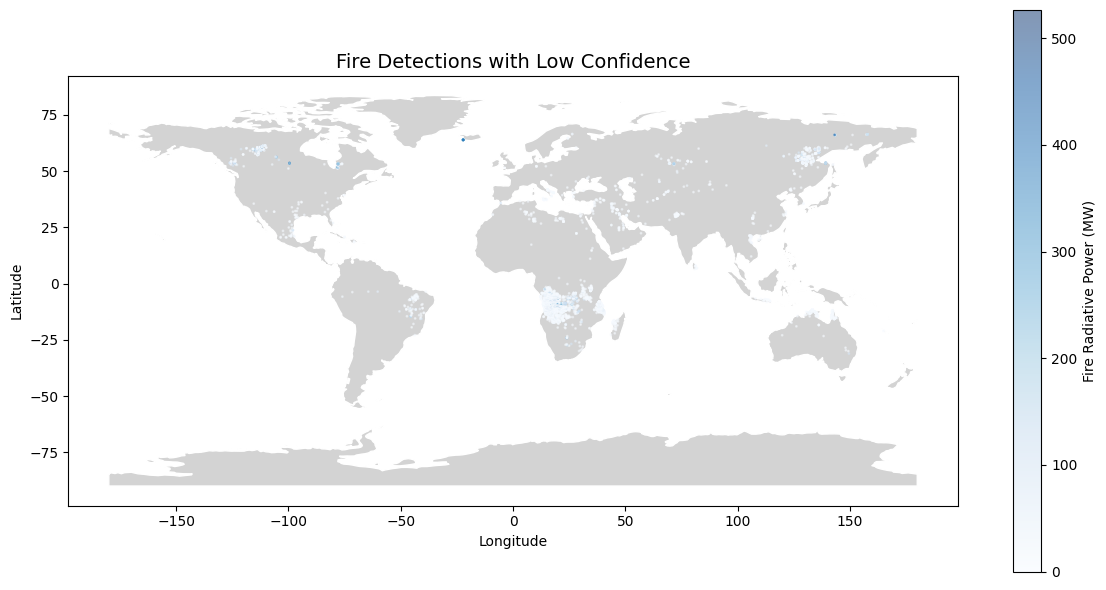

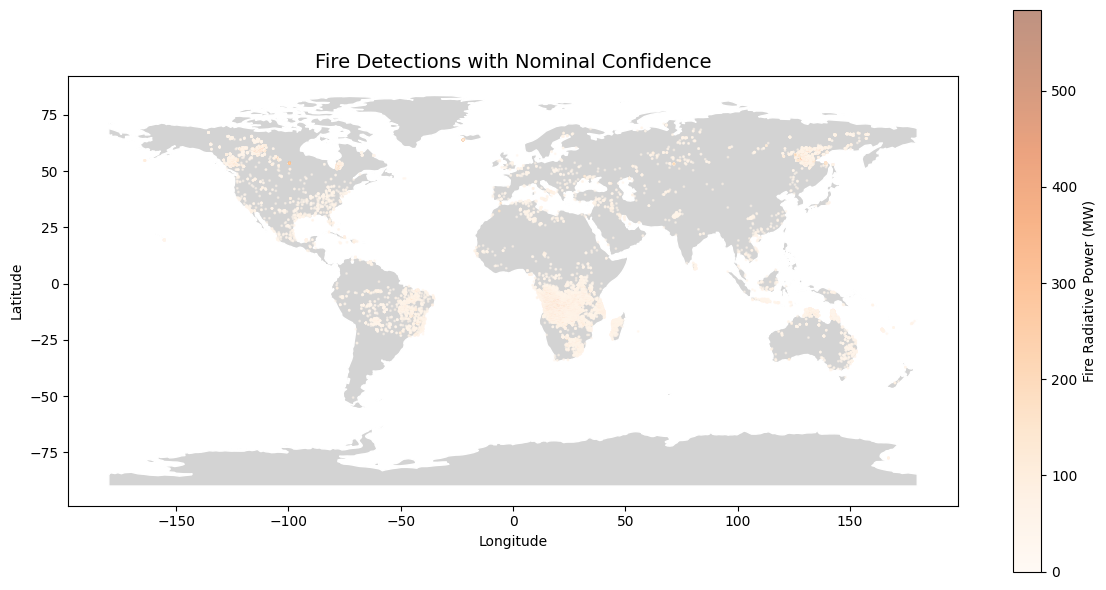

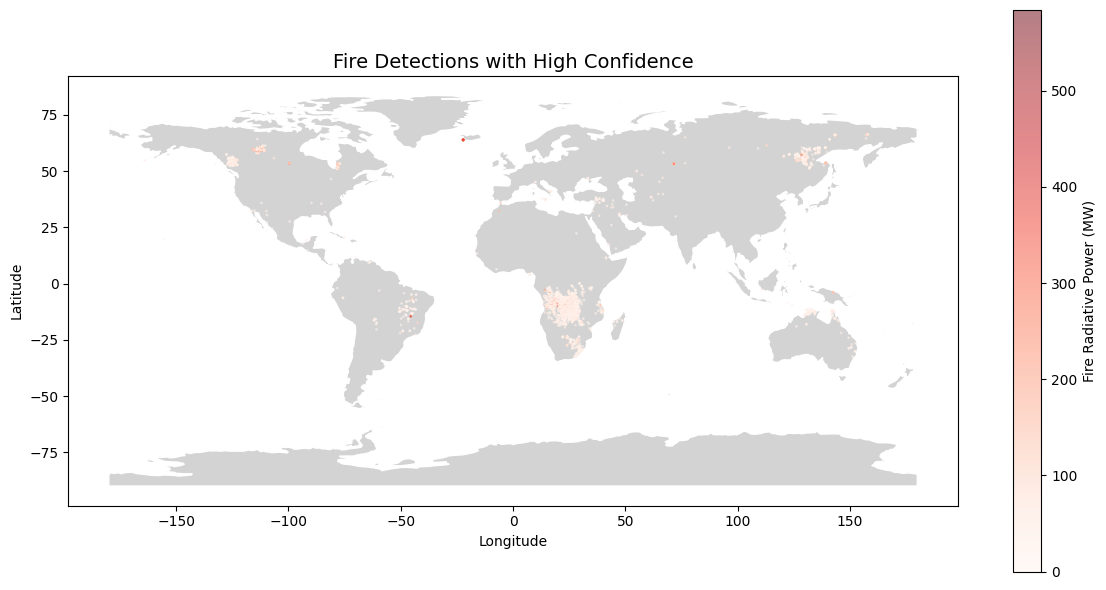

In [166]:
from matplotlib.colors import LogNorm

world = gpd.read_file(geodatasets.get_path("naturalearth.land"))



# Define a function to plot fire incidents by confidence level
def plot_confidence_world_map(conf_level, color_map):
    subset = df[df['confidence'] == conf_level]
    fig, ax = plt.subplots(figsize=(12, 6))
    world.plot(ax=ax, color='lightgrey', edgecolor='white')
    scatter = ax.scatter(
        subset['longitude'],
        subset['latitude'],
        c=subset['frp'],  # Use FRP for intensity
        cmap=color_map,
        s=1,
        alpha=0.5
    )
    ax.set_title(f'Fire Detections with {conf_level} Confidence', fontsize=14)
    plt.colorbar(scatter, ax=ax, label='Fire Radiative Power (MW)')
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    plt.tight_layout()
    return fig

# Generate plots for all three confidence levels
fig_low = plot_confidence_world_map('Low', 'Blues')
fig_nominal = plot_confidence_world_map('Nominal', 'Oranges')
fig_high = plot_confidence_world_map('High', 'Reds')

We see some concentrated instances across the planet in specific regions. Let's dive deeper and see what we're dealing with.

## Zoom in on Regional Fire Activity
Let’s zoom into a particular region — e.g., Central Africa — to visualize clustering of fires.

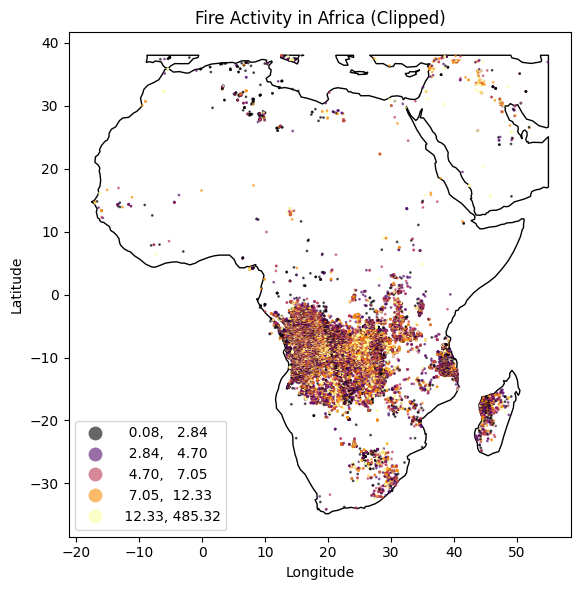

In [167]:
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import geodatasets

# Step 1: Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df['longitude'], df['latitude']),
    crs='EPSG:4326'
)

# Step 2: Define Africa bounding box and clip both datasets
bbox = [-20, -35, 55, 38]  # [minx, miny, maxx, maxy]

# Load and align world basemap
world = gpd.read_file(geodatasets.get_path("naturalearth.land")).to_crs("EPSG:4326")
world_africa = world.clip(bbox)

# Clip fire data to same bbox
gdf_africa = gdf.cx[bbox[0]:bbox[2], bbox[1]:bbox[3]]

# Step 3: Plot
fig, ax = plt.subplots(figsize=(12, 6))
world_africa.plot(ax=ax, color="white", edgecolor="black")  # use clipped land only
gdf_africa.plot(
    ax=ax,
    column="frp",
    cmap="inferno",
    markersize=1,
    legend=True,
    alpha=0.6,
    scheme="quantiles"
)

ax.set_title("Fire Activity in Africa (Clipped)")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.tight_layout()
plt.show()




- **High fire density in Central and Southern Africa** (e.g., DRC, Angola, Zambia, northern Mozambique) aligns with **savanna and dry forest biomes**, where vegetation is flammable and seasonal burning is common.
- These fires are likely driven by a combination of:
  - **Agricultural burning practices** such as slash-and-burn (swidden) farming, field clearing, and charcoal production.
  - **Dry season climatic conditions**, which lower moisture levels in vegetation, making landscapes more fire-prone.
  - **Low regulation or enforcement**, particularly in rural areas with subsistence farming.
- **Relatively sparse fire activity in North Africa** reflects the **arid climate of the Sahara**, where vegetation is too sparse to support widespread fire propagation.
- **Localized fires in Madagascar and West Africa** may be attributed to **deforestation**, **pasture management**, and **climate-driven variability** in fire weather.

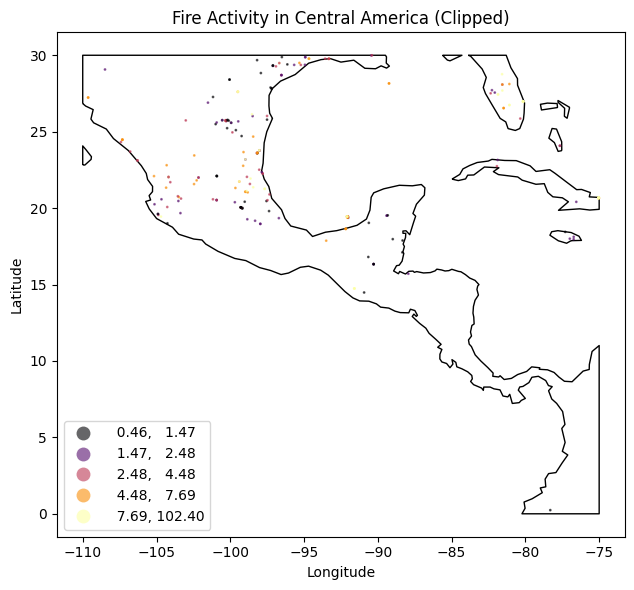

In [168]:
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import geodatasets

# Step 1: Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df['longitude'], df['latitude']),
    crs='EPSG:4326'
)

# Step 2: Define Central America bounding box and clip
bbox_ca = [-110, 0, -75, 30]  # [minx, miny, maxx, maxy] --> Mexico to Panama

# Load and align world basemap
world = gpd.read_file(geodatasets.get_path("naturalearth.land")).to_crs("EPSG:4326")
world_ca = world.clip(bbox_ca)

# Clip fire data to the same bbox
gdf_ca = gdf.cx[bbox_ca[0]:bbox_ca[2], bbox_ca[1]:bbox_ca[3]]

# Step 3: Plot
fig, ax = plt.subplots(figsize=(12, 6))
world_ca.plot(ax=ax, color="white", edgecolor="black")
gdf_ca.plot(
    ax=ax,
    column="frp",
    cmap="inferno",
    markersize=1,
    legend=True,
    alpha=0.6,
    scheme="quantiles"
)

ax.set_title("Fire Activity in Central America (Clipped)")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.tight_layout()
plt.show()



- **Concentrated fire activity** is observed in **southern and central Mexico**, particularly in the Yucatán Peninsula and along the Sierra Madre.
- Moderate fire clusters appear in **Guatemala and Honduras**, while **Nicaragua and Panama** show sparse, scattered activity.
- Fires in this region show a wide range of **Fire Radiative Power (FRP)**, with some outliers exceeding 100 MW, though most are relatively low.

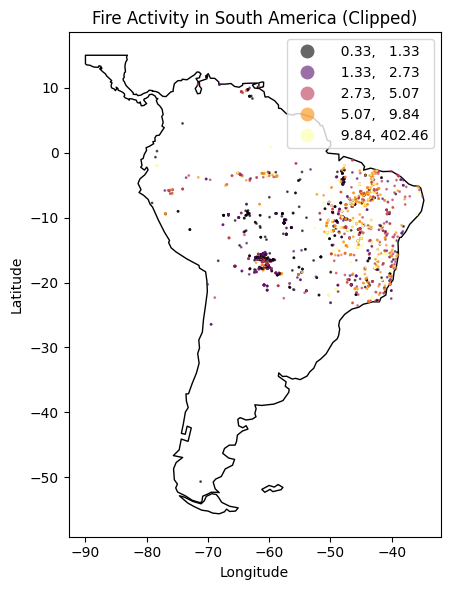

In [169]:

# Step 1: Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df['longitude'], df['latitude']),
    crs='EPSG:4326'
)

# Step 2: Define South America bounding box and clip
bbox_sa = [-90, -60, -30, 15]  # [minx, miny, maxx, maxy]

# Load and align world basemap
world = gpd.read_file(geodatasets.get_path("naturalearth.land")).to_crs("EPSG:4326")
world_sa = world.clip(bbox_sa)

# Clip fire data to the same bbox
gdf_sa = gdf.cx[bbox_sa[0]:bbox_sa[2], bbox_sa[1]:bbox_sa[3]]

# Step 3: Plot
fig, ax = plt.subplots(figsize=(12, 6))
world_sa.plot(ax=ax, color="white", edgecolor="black")
gdf_sa.plot(
    ax=ax,
    column="frp",
    cmap="inferno",
    markersize=1,
    legend=True,
    alpha=0.6,
    scheme="quantiles"
)

ax.set_title("Fire Activity in South America (Clipped)")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.tight_layout()
plt.show()



- The **most intense fire activity** is located in **central and southeastern Brazil**, spanning across the Cerrado and parts of the Amazon basin.
- Additional fire clusters are found in **eastern Bolivia**, **Paraguay**, and **northern Argentina**, especially near agricultural and grazing regions.
- The **Amazon basin** in the northwest shows a more diffuse fire pattern, likely constrained by rainforest canopy coverage and detection limits.
- Southern cone countries (Chile, Argentina) show sparse, isolated fire events.

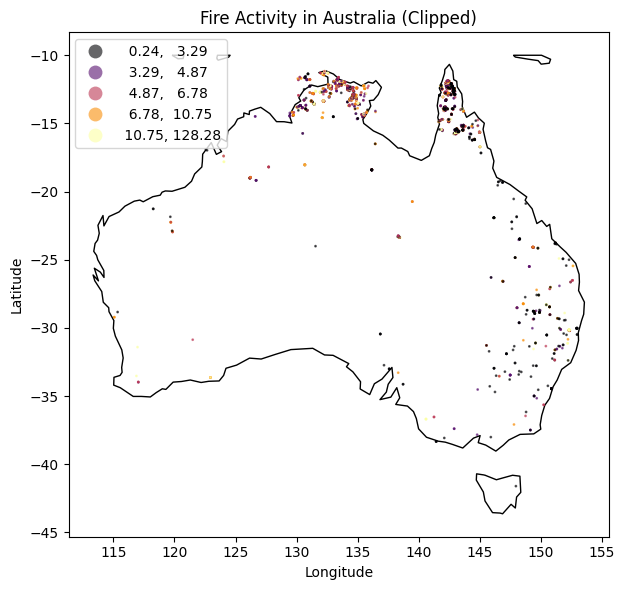

In [191]:
bbox_aus = [112, -44, 154, -10]

# Load and align world basemap
world = gpd.read_file(geodatasets.get_path("naturalearth.land")).to_crs("EPSG:4326")
world_aus = world.clip(bbox_aus)

# Clip fire data to the same bbox
gdf_aus = gdf.cx[bbox_aus[0]:bbox_aus[2], bbox_aus[1]:bbox_aus[3]]

# Step 3: Plot
fig, ax = plt.subplots(figsize=(12, 6))
world_aus.plot(ax=ax, color="white", edgecolor="black")
gdf_aus.plot(
    ax=ax,
    column="frp",
    cmap="inferno",
    markersize=1,
    legend=True,
    alpha=0.6,
    scheme="quantiles"
)

ax.set_title("Fire Activity in Australia (Clipped)")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.tight_layout()
plt.show()

- **Northern Australia** (especially near the coasts of Northern Territory and Queensland) exhibits the **highest concentration of fire events**, with several high-FRP hotspots.
- Fires are also distributed along the **eastern and southwestern coasts**, though with generally lower radiative intensity.
- **Central Australia** shows sparse activity, likely due to desert terrain and limited fuel availability.
- The **color gradient (inferno colormap)** indicates increasing FRP from black to yellow, highlighting intense fire pockets.
- The **legend quantiles** divide FRP into 5 categories, ranging from low (~0.24) to extreme (~128 MW).

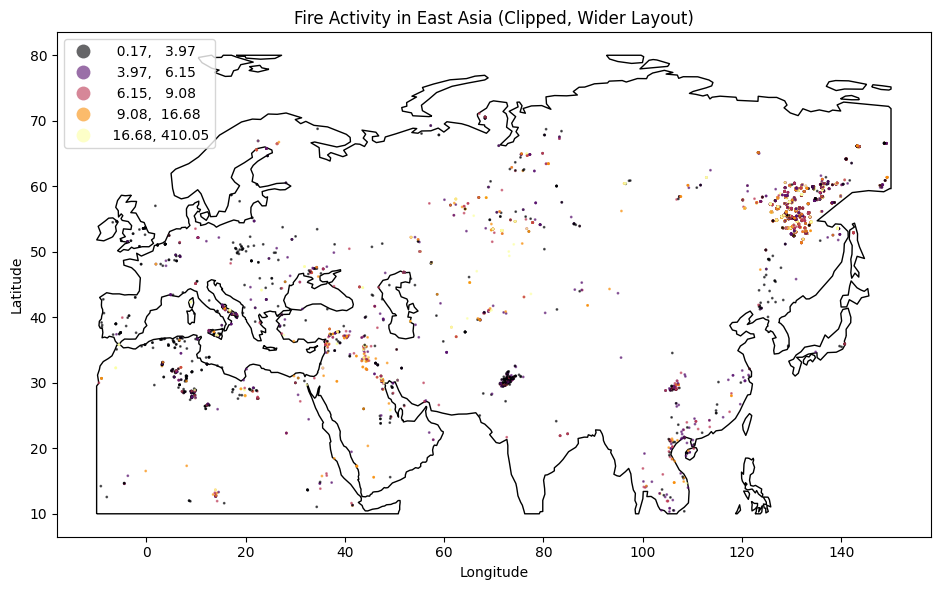

In [195]:
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import geodatasets

# Step 1: Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df['longitude'], df['latitude']),
    crs='EPSG:4326'
)

# Step 2: Define East Asia bounding box and clip
bbox_eurasia = [-10, 10, 150, 80]


# Load and align world basemap
world = gpd.read_file(geodatasets.get_path("naturalearth.land")).to_crs("EPSG:4326")
world_east_asia = world.clip(bbox_eurasia)

# Clip fire data to East Asia
gdf_east_asia = gdf.cx[bbox_eurasia[0]:bbox_eurasia[2], bbox_eurasia[1]:bbox_eurasia[3]]

# Step 3: Plot
fig, ax = plt.subplots(figsize=(14, 6))  # wider layout
world_east_asia.plot(ax=ax, color="white", edgecolor="black")
gdf_east_asia.plot(
    ax=ax,
    column="frp",
    cmap="inferno",
    markersize=1,
    legend=True,
    alpha=0.6,
    scheme="quantiles"
)

ax.set_title("Fire Activity in East Asia (Clipped, Wider Layout)")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.tight_layout()
plt.show()


- The **highest fire density** is concentrated in **northeastern China**, particularly in Heilongjiang and Jilin provinces.
- Additional clusters are visible in **central and southeastern China**, with sparse but notable activity extending toward the Korean Peninsula and southern Japan.
- **Central Asia, Siberia, and the Russian Far East** show minimal fire activity within the clipped extent.

## 4. Correlation Analysis of Satellite Readings
We examine the correlation between satellite readings and fire radiative power using a heatmap and scatter plots.

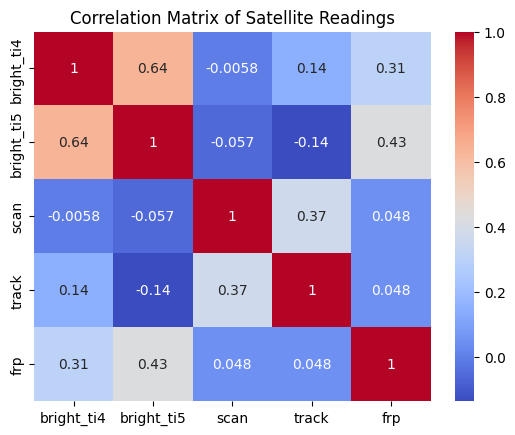

In [171]:
features = ['bright_ti4', 'bright_ti5', 'scan', 'track', 'frp']
sns.heatmap(df[features].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix of Satellite Readings")
plt.show()

### Correlation Matrix: Satellite Readings and Fire Radiative Power (FRP)

- **`bright_ti5` vs `frp`**:  
  - Highest positive correlation with FRP (`0.43`).
  - Indicates that brightness temperature in the thermal infrared (I5) channel is a strong indicator of fire intensity.

- **`bright_ti4` vs `frp`**:  
  - Moderate correlation (`0.31`).
  - Confirms that mid-infrared readings (I4) are also positively associated with FRP, but slightly less than I5.

- **`scan` and `track` vs `frp`**:  
  - Both show **very weak correlations** (`0.048`), reinforcing that geometric factors like spatial resolution have minimal direct impact on radiative power.

- **`bright_ti4` vs `bright_ti5`**:  
  - Strong mutual correlation (`0.64`), reflecting that both bands measure related aspects of thermal emission, likely driven by similar physical phenomena.


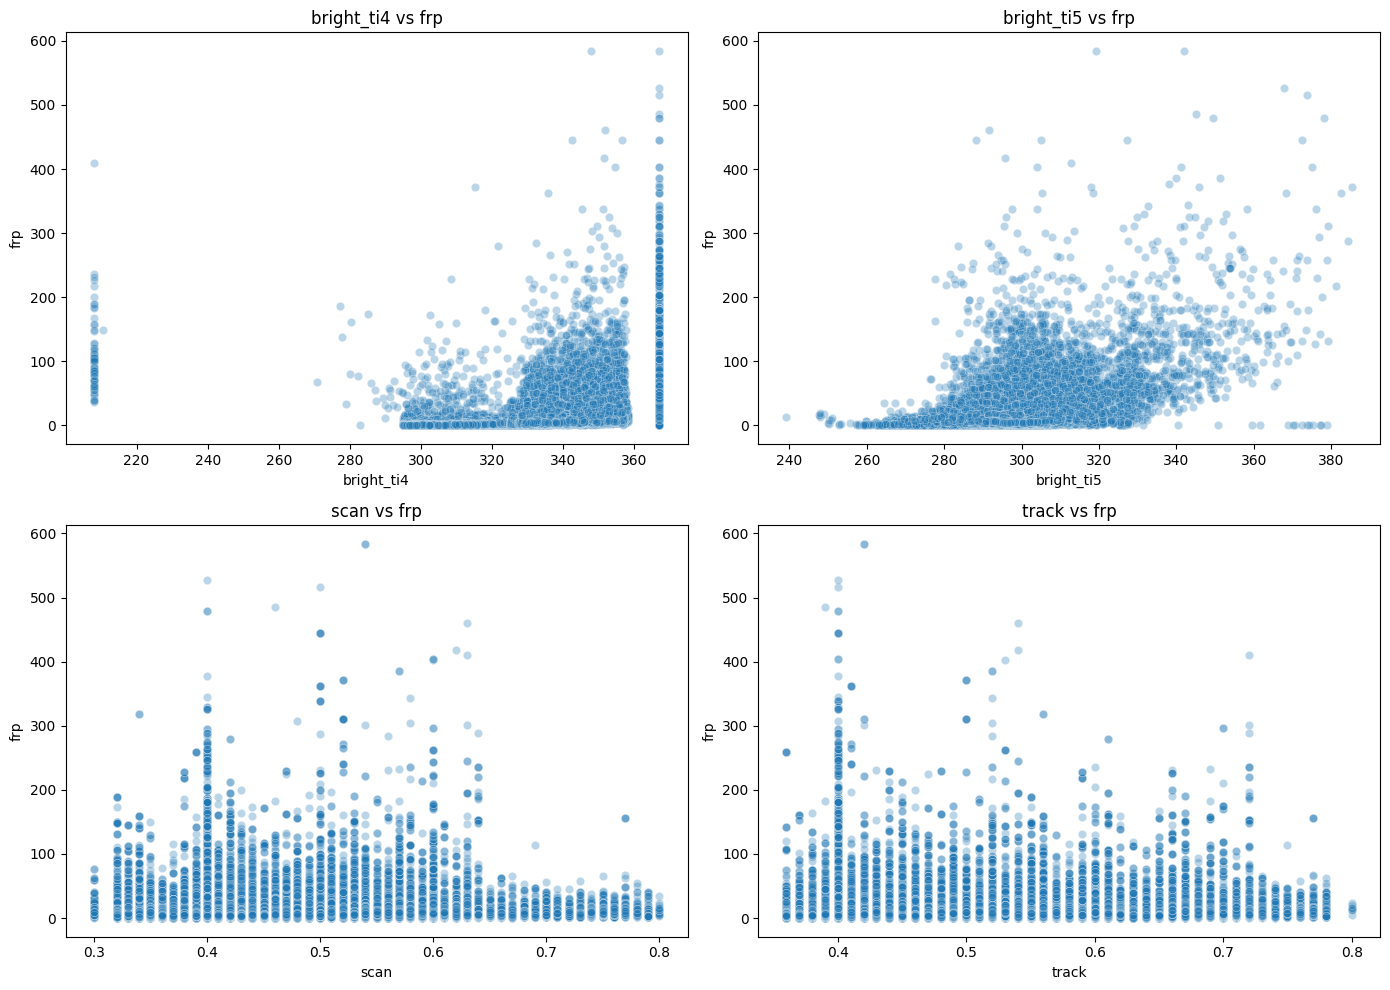

In [172]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
sns.scatterplot(data=df, x='bright_ti4', y='frp', ax=axes[0, 0], alpha=0.3)
sns.scatterplot(data=df, x='bright_ti5', y='frp', ax=axes[0, 1], alpha=0.3)
sns.scatterplot(data=df, x='scan', y='frp', ax=axes[1, 0], alpha=0.3)
sns.scatterplot(data=df, x='track', y='frp', ax=axes[1, 1], alpha=0.3)
axes[0, 0].set_title("bright_ti4 vs frp")
axes[0, 1].set_title("bright_ti5 vs frp")
axes[1, 0].set_title("scan vs frp")
axes[1, 1].set_title("track vs frp")
plt.tight_layout()
plt.show()

### Scatterplot Analysis: FRP vs Satellite-Derived Variables

#### Top-Left: `bright_ti4` vs `frp`
- Displays a strong positive correlation.
- Higher `bright_ti4` values (brightness temperature from the mid-infrared band) are clearly associated with higher FRP.
- The clustering suggests that `bright_ti4` is a reliable indicator of fire intensity.

#### Top-Right: `bright_ti5` vs `frp`
- A moderate positive trend is present, though the relationship is weaker than with `bright_ti4`.
- Indicates that thermal brightness (`bright_ti5`) does contribute to FRP prediction, but with more noise.

---

#### Bottom-Left: `scan` vs `frp`
- Exhibits no clear correlation.
- Distribution of FRP across the `scan` range appears diffuse and non-linear.
- Suggests that `scan` (across-track pixel resolution) has limited influence on fire intensity.

#### Bottom-Right: `track` vs `frp`
- Also shows no strong association with FRP.
- Similar to `scan`, the `track` variable does not exhibit a predictive relationship with fire radiative power.
- May reflect viewing geometry effects, but not directly related to fire strength.

---

### Summary
Among the four variables analyzed:
- `bright_ti4` is the most informative and positively correlated with FRP.
- `bright_ti5` has secondary value with moderate correlation.
- `scan` and `track` are largely uninformative for modeling FRP directly.

## 5. Feature Selection for Classification
We identify the most predictive features for classifying fire confidence using ANOVA F-test.

In [173]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif

# Filter rows where confidence is not null
df_class = df[df['confidence'].notnull()].copy()

# Encode 'confidence'
le_conf = LabelEncoder()
df_class['confidence_encoded'] = le_conf.fit_transform(df_class['confidence'])

# Encode 'daynight'
le_dn = LabelEncoder()
df_class['daynight_encoded'] = le_dn.fit_transform(df_class['daynight'])

# Define features and target
X_class = df_class[['bright_ti4', 'bright_ti5', 'scan', 'track', 'latitude', 'longitude', 'acq_time', 'daynight_encoded']]
y_class = df_class['confidence_encoded']

# Scale features
scaler = StandardScaler()
X_class_scaled = scaler.fit_transform(X_class)

# Feature selection
selector = SelectKBest(score_func=f_classif, k='all')
X_selected = selector.fit_transform(X_class_scaled, y_class)
selected_features = X_class.columns[selector.get_support()].tolist()

# Output selected features
print(selected_features)

['bright_ti4', 'bright_ti5', 'scan', 'track', 'latitude', 'longitude', 'acq_time', 'daynight_encoded']


## 6. Classification Models: Logistic Regression and Random Forest
We use top features to classify fire incidents into Low, Nominal, or High confidence.


Logistic Regression Classification Report
              precision    recall  f1-score   support

        High       0.93      0.97      0.95      1474
         Low       0.70      0.15      0.25      1437
     Nominal       0.95      1.00      0.97     19471

    accuracy                           0.94     22382
   macro avg       0.86      0.71      0.72     22382
weighted avg       0.93      0.94      0.92     22382



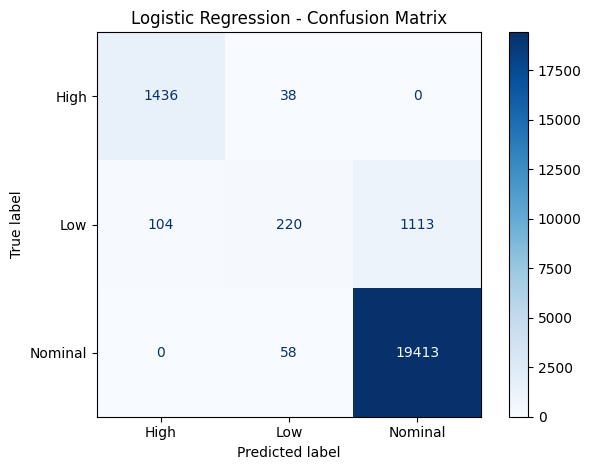


Random Forest Classification Report
              precision    recall  f1-score   support

        High       0.97      0.98      0.97      1474
         Low       0.76      0.67      0.71      1437
     Nominal       0.98      0.99      0.98     19471

    accuracy                           0.96     22382
   macro avg       0.90      0.88      0.89     22382
weighted avg       0.96      0.96      0.96     22382



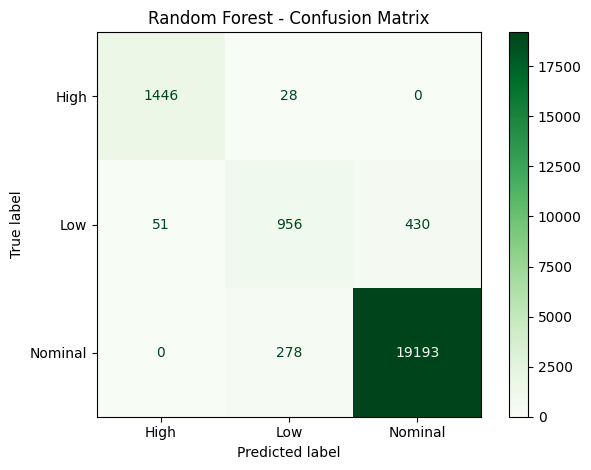

In [194]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Split and scale data
X_train, X_test, y_train, y_test = train_test_split(
    X_class[selected_features], y_class, test_size=0.3, random_state=42, stratify=y_class
)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train models
logreg = LogisticRegression(max_iter=1000, multi_class='multinomial')
logreg.fit(X_train_scaled, y_train)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Evaluate Logistic Regression
print("\nLogistic Regression Classification Report")
print(classification_report(y_test, logreg.predict(X_test_scaled), target_names=le.classes_))

# Confusion Matrix for Logistic Regression
cm_logreg = confusion_matrix(y_test, logreg.predict(X_test_scaled))
disp_logreg = ConfusionMatrixDisplay(confusion_matrix=cm_logreg, display_labels=le.classes_)
disp_logreg.plot(cmap='Blues')
plt.title("Logistic Regression - Confusion Matrix")
plt.tight_layout()
plt.show()

# Evaluate Random Forest
print("\nRandom Forest Classification Report")
print(classification_report(y_test, rf.predict(X_test), target_names=le.classes_))

# Confusion Matrix for Random Forest
cm_rf = confusion_matrix(y_test, rf.predict(X_test))
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=le.classes_)
disp_rf.plot(cmap='Greens')
plt.title("Random Forest - Confusion Matrix")
plt.tight_layout()
plt.show()

### Classification Performance Summary: Logistic Regression vs Random Forest

#### **Logistic Regression**
- **Overall Accuracy**: 94%
- **Strength**: Very high precision and recall for the `Nominal` and `High` classes.
- **Weakness**: Struggles significantly with the `Low` class:
  - Precision: 0.70
  - Recall: 0.15
  - F1-score: 0.25
- Likely affected by **class imbalance** and **linear limitations**.

#### **Random Forest**
- **Overall Accuracy**: 96%
- **Strength**: High precision and recall across all classes.
  - `High`: F1-score = 0.97
  - `Nominal`: F1-score = 0.98
  - `Low`: F1-score = 0.71 (significant improvement over Logistic Regression)
- Handles class imbalance more effectively via ensemble learning.



## Feature Importance from Tree-Based Models
Feature importances help identify what inputs the models rely on most.

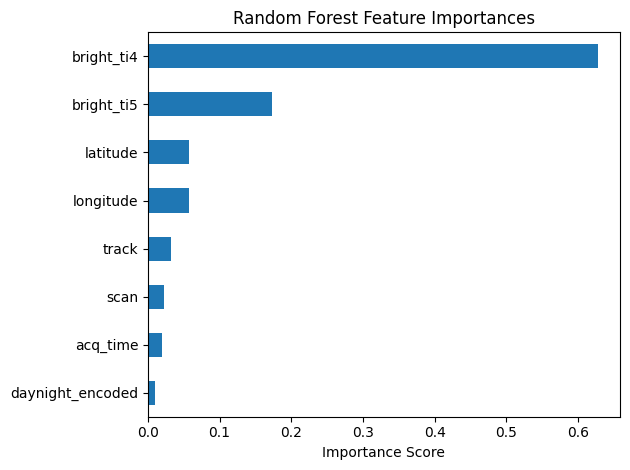

In [175]:
importances = pd.Series(rf.feature_importances_, index=selected_features)
importances.sort_values().plot(kind='barh')
plt.title('Random Forest Feature Importances')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

### Random Forest Feature Importances: Predicting Fire Radiative Power (FRP)


- **`bright_ti4` (Mid-Infrared Brightness Temperature)**  
  - Dominates the model with an importance score exceeding 0.6.
  - This confirms that mid-infrared thermal readings are the most significant determinant of FRP in the dataset.

- **`bright_ti5` (Thermal Infrared Brightness Temperature)**  
  - Second most important feature, though its contribution is significantly smaller than `bright_ti4`.
  - Suggests that both bands are valuable, but `bright_ti4` captures more relevant variance.

- **Geographic Coordinates (`latitude`, `longitude`)**  
  - Provide moderate importance, likely reflecting regional patterns or climatological differences affecting fire behavior.

- **Sensor Geometry (`track`, `scan`) and Temporal Context (`acq_time`)**  
  - Each shows minimal influence on FRP prediction.
  - These features may impact detection conditions but do not strongly drive fire intensity values.

- **`daynight_encoded`**  
  - Least important feature, indicating that whether the observation occurred during the day or night has negligible effect on FRP estimates.


## 7. Predicting FRP with Gradient Boosting Regression
We model FRP (fire intensity) using Gradient Boosting Regressor on satellite readings.

In [189]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.metrics import mean_squared_error, r2_score

# Copy the dataset
df_boost = df.copy()
X = df_boost[['bright_ti4', 'bright_ti5', 'scan', 'track', 'latitude', 'longitude', 'acq_time', 'daynight']]
y = df_boost['frp']

# Preprocessing
numeric_features = ['bright_ti4', 'bright_ti5', 'scan', 'track', 'latitude', 'longitude']
time_transformer = Pipeline(steps=[
    ('log', FunctionTransformer(np.log1p, validate=True)),
    ('scale', StandardScaler())
])
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first')

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('time', time_transformer, ['acq_time']),
    ('cat', categorical_transformer, ['daynight'])
])

# Pipeline definition
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(random_state=42))
])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("Completed data processing pipeline, switching to hyperparameter tuning")

# Grid search parameter space
param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__learning_rate': [0.01, 0.05, 0.1],
    'regressor__max_depth': [3, 5],
    'regressor__min_samples_split': [2, 5],
    'regressor__min_samples_leaf': [1, 2],
    'regressor__subsample': [0.8, 1.0]
}

# GridSearchCV with verbosity
grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=2,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

# Evaluate best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\nGradient Boosting Model evaluation")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

print("\nBest Parameters:")
print(grid_search.best_params_)

Completed data processing pipeline, switching to hyperparameter tuning
Fitting 3 folds for each of 96 candidates, totalling 288 fits
[CV] END regressor__learning_rate=0.01, regressor__max_depth=3, regressor__min_samples_leaf=1, regressor__min_samples_split=2, regressor__n_estimators=100, regressor__subsample=0.8; total time=   4.7s
[CV] END regressor__learning_rate=0.01, regressor__max_depth=3, regressor__min_samples_leaf=1, regressor__min_samples_split=2, regressor__n_estimators=100, regressor__subsample=0.8; total time=   4.9s
[CV] END regressor__learning_rate=0.01, regressor__max_depth=3, regressor__min_samples_leaf=1, regressor__min_samples_split=2, regressor__n_estimators=100, regressor__subsample=0.8; total time=   4.9s
[CV] END regressor__learning_rate=0.01, regressor__max_depth=3, regressor__min_samples_leaf=1, regressor__min_samples_split=2, regressor__n_estimators=100, regressor__subsample=1.0; total time=   5.7s
[CV] END regressor__learning_rate=0.01, regressor__max_depth=3,

### Gradient Boosting FRP Prediction
- RMSE of ~16.23 MW suggests the model predicts fire power with moderate accuracy.
- R² Score of **~0.5** indicates it captures half of the variance in FRP.
- Despite our best efforts, this is stuck at nearly a 50% predictive power. T

This suggests that the dataset could benefit from additional engineered or spatial-temporal features.

## 8. Anomaly Detection with Isolation Forest
We detect unusual fire events based on their satellite signature using unsupervised learning.

In [197]:
X_iso = scaler.fit_transform(X_reg)
iso_model = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
df['anomaly'] = iso_model.fit_predict(X_iso)
df['is_anomaly'] = df['anomaly'] == -1
print(f"\nAnomalies detected: {df['is_anomaly'].sum()} out of {len(df)} records")


Anomalies detected: 747 out of 74605 records


### Anomaly Detection via Isolation Forest
- Anomalies detected: 746 out of 74605 records
- These may represent unusually intense fires, sensor noise, or rare spatial events.

## Anomaly Distribution Analysis
Explore the characteristics of the 746 anomalous fire detections identified earlier.

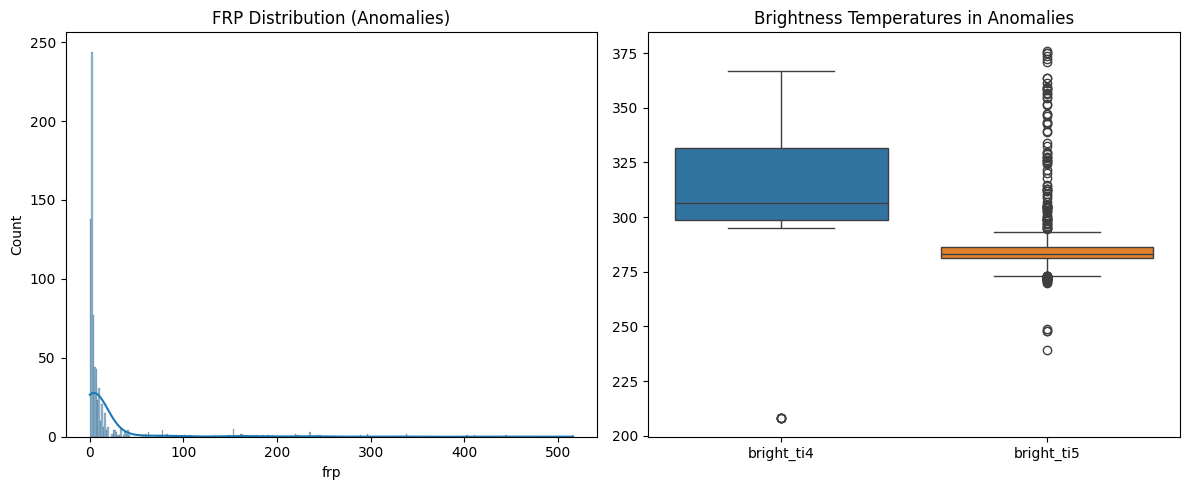

In [208]:
df_anomalies = df[df['is_anomaly']]

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: FRP Distribution
sns.histplot(df_anomalies['frp'], ax=ax[0], kde=True)
ax[0].set_title('FRP Distribution (Anomalies)')

# Plot 2: Brightness Temperatures
sns.boxplot(data=df_anomalies[['bright_ti4', 'bright_ti5']], ax=ax[1])
ax[1].set_title('Brightness Temperatures in Anomalies')

plt.tight_layout()
plt.show()


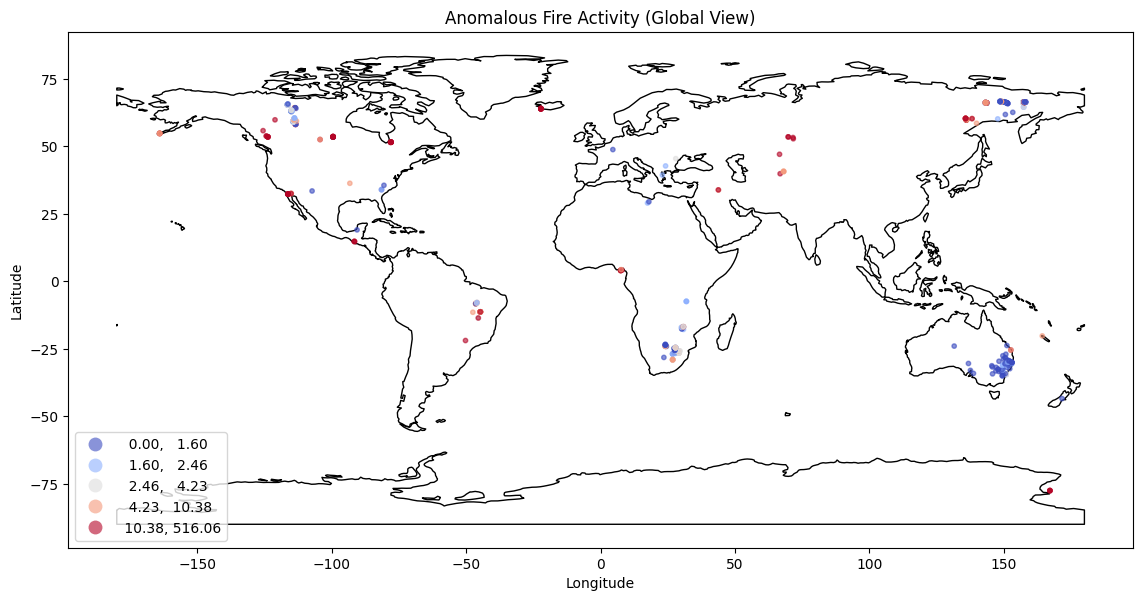

In [209]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Step 1: Convert df_anomalies to a GeoDataFrame
gdf_anomalies = gpd.GeoDataFrame(
    df_anomalies,
    geometry=gpd.points_from_xy(df_anomalies['longitude'], df_anomalies['latitude']),
    crs='EPSG:4326'
)

# Step 2: Load and align world basemap
world = gpd.read_file(geodatasets.get_path("naturalearth.land")).to_crs("EPSG:4326")

# Step 3: Plot anomalies on global map
fig, ax = plt.subplots(figsize=(12, 6))
world.plot(ax=ax, color="white", edgecolor="black")
gdf_anomalies.plot(
    ax=ax,
    column="frp",
    cmap="coolwarm",
    markersize=10,
    legend=True,
    alpha=0.6,
    scheme="quantiles"
)

ax.set_title("Anomalous Fire Activity (Global View)")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.tight_layout()
plt.show()

### Anomaly Analysis in Fire Radiative Power (FRP) Data

This figure presents a multi-faceted exploration of **anomalous fire events**, focusing on their FRP distribution, spatial locations, and brightness temperature characteristics.

---

#### 1. FRP Distribution (Anomalies)
- The leftmost histogram reveals that anomalous FRP values are **heavily right-skewed**, with the majority concentrated below 50 MW.
- A small number of extreme outliers exceed 400 MW, indicating rare but intense fire events.
- The kernel density overlay confirms a long-tailed distribution, suggesting that most anomalies are relatively low in intensity with a few exceptional cases.

---

#### 2. Brightness Temperatures in Anomalies
- The rightmost boxplot compares `bright_ti4` (mid-infrared) and `bright_ti5` (thermal infrared) brightness temperatures among anomalies.
- `bright_ti4` shows **greater variability**, including a lower-end outlier below 220K, which could indicate a misreading or unusual atmospheric condition.
- `bright_ti5` is more tightly distributed, with its interquartile range concentrated around 280–300K but featuring a dense band of upper outliers.
- This suggests that **anomalies tend to coincide with elevated `bright_ti5` values**, reinforcing its role as a thermal signature of intense fire events.

---

#### 3. Anomaly Spatial Distribution
- The central scatter plot maps the **geographic distribution of anomalous fires** using latitude and longitude.
- Anomalies are **globally dispersed**, with visible clusters across North America, Central Africa, Southeast Asia, and Australia.
- Color intensity reflects FRP magnitude, indicating that **high-FRP anomalies are rare and geographically isolated**.
